In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import os
import sys
from ocp_table_tpot.globals import Globals as gd
from tpot import TPOTRegressor
sys.path.insert(0,'..')
from src.models.model import HistoricalMedian,XGBoost,LinearModel,RF,KNN,SVM,mase,TimeSeriesSplitImproved
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,RANSACRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from skgarden.quantile import RandomForestQuantileRegressor
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.preprocessing import FunctionTransformer
from copy import copy
from tpot.builtins import StackingEstimator
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import make_pipeline, make_union
from catboost import CatBoostRegressor,Pool,cv
import umap

df_tsfresh = pd.read_pickle(f'../data/processed/train_test_tsfresh_6.pkl').reset_index(level = 0)
data_dict = pd.read_pickle(f'../data/processed/data_dict_all.pkl')


In [8]:
year = 2019
tgt = 'rougher.output.recovery'
X = data_dict[year]['X_train_tsclean']
y = data_dict[year]['y_train_tsclean']
print(f'1) X shape: {X.shape},y: {y.shape}')


X_test=  data_dict[year]['X_test_ts']
print(f'1) Test shape: {X_test.shape}, train: {X.shape}')

inds_y = y[(y[tgt] > 5) & (y[tgt] < 100)].index
inds_common = inds_y
X = X.loc[inds_common,]

print(f'2) Test shape: {X_test.shape}, train: {X.shape}')

y = y.loc[inds_common, tgt]

X = X.sample(frac=0.8,random_state=123).sort_index().dropna()
y= y[X.index]
X_filt = X.filter(regex  ="rougher",axis = 1)

1) X shape: (11371, 330),y: (12501, 7)
1) Test shape: (5856, 330), train: (11371, 330)


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


2) Test shape: (5856, 330), train: (12501, 330)


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\pandas\core\sorting.py:257: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  items = np.asanyarray(items)


# Base models

In [9]:

CatBoost = CatBoostRegressor(loss_function='MAE',random_seed =123,learning_rate=0.1,max_depth=8,task_type='GPU',od_type = 'Iter',od_wait= 15,iterations = 2000)


In [10]:
n_folds = 8

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.005, random_state=1,max_iter = 2000))

def cv_catboost(model,X_base=None,y=None):
#     pool = Pool(X_base,y)
#     #,task_type='GPU',od_type = 'Iter',od_wait= 15
#     params['task_type'] = "GPU"
#     params['od_type'] = "Iter"
#     params['od_wait'] = 20
#     params['has_time']= True
#     params['plot']=False
#     params['verbose_eval'] = 100
#     params['shuffle'] = False
#     params['fold_count'] = 5
#     params['early_stopping_rounds'] = 15
#     params['random_seed'] = 123
#     scores = cv(pool,params)
   
    cv = KFold(n_folds, shuffle=False, random_state=42)
    scores = []
    preds_all_alt = np.empty_like(y)
    preds_all_base = np.empty_like(y)
    
    true_all =np.empty_like(y)

    for fold_n, (train_index, valid_index) in enumerate(cv.split(X)):
    # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        print(y.shape)
        # Do the base
        model.fit(X_train.values,y_train.values.reshape(-1,),eval_set=(X_valid.values, y_valid.values.reshape(-1,)),plot=False,verbose_eval = 300)
        preds  = model.predict(X_valid.values)
        preds_all_base[valid_index] = preds
        true_all[valid_index] = y_valid
        
    oof_scores = mase(preds_all_base,true_all)
    return oof_scores


class StackingAveragedCatModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=8):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=False, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                
                instance.fit(np.array(X)[train_index], np.array(y)[train_index],eval_set=(np.array(X)[holdout_index], np.array(y)[holdout_index]),plot=False,verbose_eval = 300)

                y_pred = instance.predict(np.array(X)[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

(4999,)


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3

(4999,)


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3

(4999,)


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3

(4999,)


C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3\envs\ocp\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\abiryukov\AppData\Local\Continuum\anaconda3

{'base': 2.4051356985779484, 'alter': 2.3820198372857266}
Stacked score: 2.3972 (0.5300)



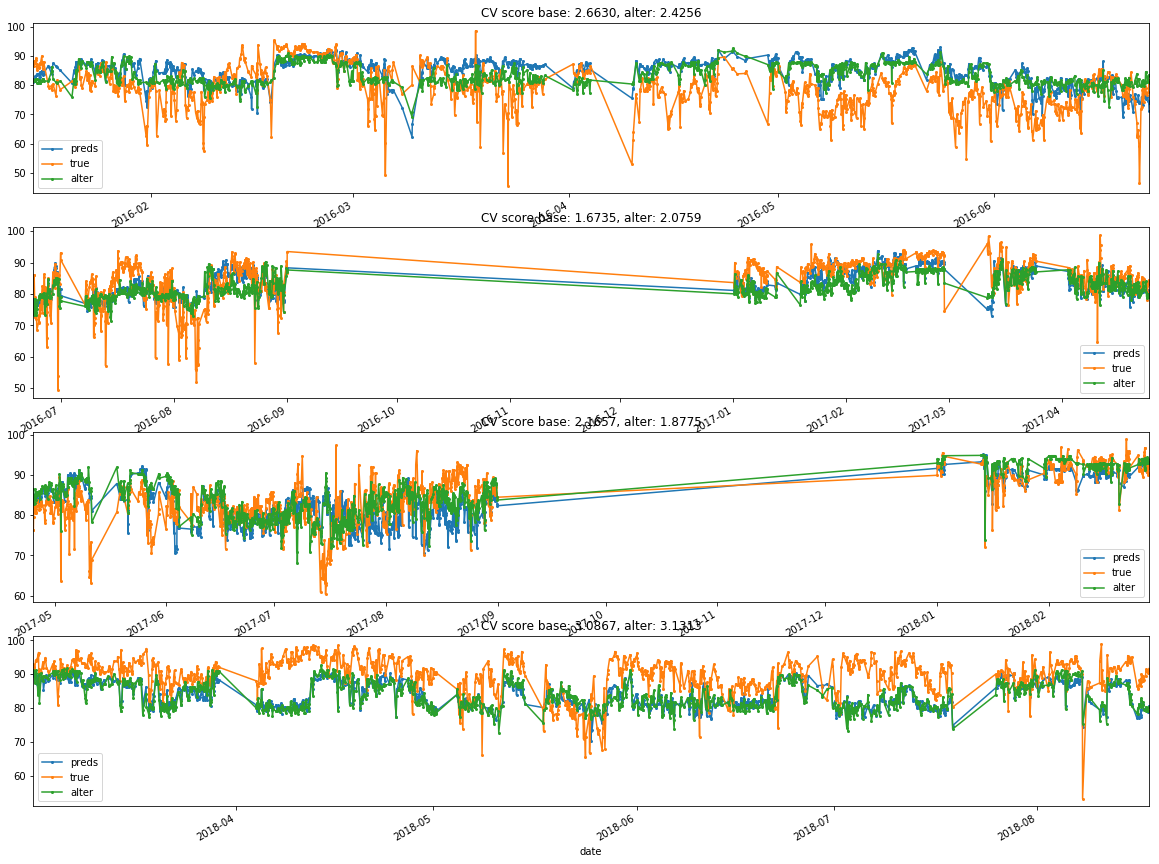

In [10]:
stacked_averaged_models = StackingAveragedCatModels(base_models = (model_lgb,model_xgb,lasso),
                                                 meta_model = model_xgb)
ax,score,oof_scores  = rmsle_cv_gen_compare(stacked_averaged_models,plot=True,X_base=X,y=y,X_alt=X_filt)
print("Stacked score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Pull the TPOT models as basic models, attach QRF and do a stacking prediction

In [16]:
lr=0.3
cat_a = CatBoostRegressor(loss_function='Quantile:alpha=0.6',random_seed =123,learning_rate=lr,task_type='GPU',od_type = 'Iter',od_wait= 15,iterations = 2500,
                          max_bin=128,**{'max_depth': 3, 'l2_leaf_reg': 0.016446781695122155})

cat_b =  CatBoostRegressor(loss_function='Quantile:alpha=0.6',random_seed =124,learning_rate=lr,task_type='GPU',od_type = 'Iter',od_wait= 15,iterations = 2500,
                          max_bin=128,**{'max_depth': 3, 'l2_leaf_reg': 0.0009296578428094183})

cat_c =  CatBoostRegressor(loss_function='Quantile:alpha=0.6',random_seed =125,learning_rate=lr,task_type='GPU',od_type = 'Iter',od_wait= 15,iterations = 2500,
                          max_bin=128,**{'max_depth': 4, 'l2_leaf_reg': 6.97} )

cat_d =  CatBoostRegressor(loss_function='Quantile:alpha=0.6',random_seed =126,learning_rate=lr,task_type='GPU',od_type = 'Iter',od_wait= 15,iterations = 2500,
                          max_bin=128,**{'max_depth': 3, 'l2_leaf_reg': 1.6343615394782727})

cat_qa = CatBoostRegressor(loss_function='Quantile:alpha=0.55',random_seed =123,learning_rate=lr,task_type='GPU',od_type = 'Iter',od_wait= 15,iterations = 2500,
                          max_bin=128,**{'max_depth': 3, 'l2_leaf_reg': 0.5073322664294757})

cat_qb =  CatBoostRegressor(loss_function='Quantile:alpha=0.55',random_seed =124,learning_rate=lr,task_type='GPU',od_type = 'Iter',od_wait= 15,iterations = 2500,
                          max_bin=128,**{'max_depth': 4, 'l2_leaf_reg': 3.7926533458959315} )
cat_qc =  CatBoostRegressor(loss_function='Quantile:alpha=0.55',random_seed =125,learning_rate=lr,task_type='GPU',od_type = 'Iter',od_wait= 15,iterations = 2500,
                          max_bin=128,**{'max_depth': 3, 'l2_leaf_reg': 0.02050105933384481})
cat_qd =  CatBoostRegressor(loss_function='MAE',random_seed =126,learning_rate=lr,task_type='GPU',od_type = 'Iter',od_wait= 15,iterations = 2000,
                          max_bin=128,**{'max_depth': 4, 'l2_leaf_reg': 11.439572030845131})

# Score 1.290 params {'max_depth': 4, 'num_leaves': 60, 'feature_fraction': '0.797', 'bagging_fraction': '0.982'}

#Score 1.280 params {'max_depth': 5, 'num_leaves': 65, 'feature_fraction': '0.879', 'bagging_fraction': '0.727'}
# Score 1.279 params {'max_depth': 7, 'num_leaves': 6, 'feature_fraction': '0.502', 'bagging_fraction': '0.217'}
#Score 1.269 params {'max_depth': 6, 'num_leaves': 6, 'feature_fraction': '0.650', 'bagging_fraction': '0.291'}


stacked_averaged_models = StackingAveragedCatModels(base_models = (cat_a,cat_b,cat_c,cat_d,cat_qa,cat_qb,cat_qc,cat_qd),
                                                 meta_model = lasso)
#,lgb_a,lgb_b,lgb_c,lgb_d),
#ax,score,oof_scores  = rmsle_cv_gen_compare(stacked_averaged_models,plot=True,X_base=X,y=y,X_alt=X_filt)

In [261]:
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


Stacking Averaged models score: 1.4514 (0.1959)


# Final predictions:



In [17]:
from sklearn.ensemble import IsolationForest
irf = IsolationForest(verbose =1,contamination='auto',behaviour='new')

def clean_target(y,wupper = int(24*10*2.5),wmean =int(24*8/0.4),wlower = int(24*4*2.5),wstd = int(24*30*2.5),upper_std=False ):
    import altair as alt
    alt.data_transformers.enable('default', max_rows=None)

    tmp = pd.DataFrame(y)
    tmp.columns=['Tgt']
    tmp.reset_index(inplace=True)

    tmp['mean'] = tmp['Tgt'].rolling(window = wmean,center=True).median().fillna(method='bfill')
    tmp['std'] = tmp['Tgt'].rolling(window = wstd,center=True).std().fillna(method='bfill')
    #tmp['upper'] = (tmp['mean']+ 1.5 * tmp['std']).fillna(method='bfill').fillna(method='ffill')
    tmp['lower'] = (tmp['mean']- 1.7 * tmp['std']).fillna(method='bfill').fillna(method='ffill')
    #tmp['lower'] = tmp['Tgt'].rolling(window = wlower,center=True).quantile(0.04).fillna(method='bfill')
    tmp['upper'] = tmp['Tgt'].rolling(window = wupper).quantile(0.98).fillna(method='bfill')
    if upper_std:
        tmp['upper'] = (tmp['mean']+ 1.7 * tmp['std']).fillna(method='bfill').fillna(method='ffill')


    tmp_melt = tmp.melt(id_vars = ['date'])
    y = y.loc[tmp[(tmp.Tgt > tmp.lower) & (tmp.Tgt < tmp.upper)].date,]
    
    ch = alt.Chart(width=1000,data = tmp_melt).mark_point(filled=True,size= 5).encode(
                x='date',
                y='value:Q',
                color='variable:N',
                #shape = 'variable',
                opacity=alt.value(0.6))
    
    
    return y,tmp_melt,ch


preds_all = []
model = stacked_averaged_models
for year in [2016,2017]:
    print(year)
    year_train = 2019
    data_dict = pd.read_pickle(f'../data/processed/data_dict_all.pkl')
    X_test = data_dict[year]['X_test_ts'].copy().filter(regex  ="rougher",axis = 1)
    
    tgt = "rougher.output.recovery"
    
    X = data_dict[year_train]['X_train_tsclean'].copy().tz_convert(None)
    print(f'1a) Test shape: {X_test.shape}, train: {X.shape}')
    y = data_dict[year_train]['y_train_tsclean'][tgt].copy().dropna().tz_convert(None)
    y = y[(y>45) & (y <99)]
    #Fit Isolation RF
    #irf.fit(X)
    #irf_preds = irf.predict(X)
   # X= X.loc[irf_preds > 0]
    print(f'1b) Test shape: {X_test.shape}, train: {X.shape} after FILT')
    
    #y,tmp_melt,chrr = clean_target(y,upper_std=True)
   # print(ch)

    inds = X.index.intersection(y.index)
    X = X.loc[inds].filter(regex  ="rougher",axis = 1)
    y = y.loc[inds]
    print(f'1c) Test shape: {X_test.shape}, train: {X.shape} after intersect with Y')

    model.fit(X.values, y)
    ypred_r = model.predict(X_test.values)
    preds_r = pd.DataFrame(data = {'date':X_test.index, tgt:ypred_r}).set_index('date')
    
    tgt = "final.output.recovery"
    
    X = data_dict[year_train]['X_train_tsclean'].copy().tz_convert(None)
    X_test = data_dict[year]['X_test_ts'].copy()
    y = data_dict[year_train]['y_train_tsclean'][tgt].copy().dropna().tz_convert(None)
    y = y[(y>35) & (y <97)]
    print(f'2a) Test shape: {X_test.shape}, train: {X.shape}')
    # Data cleaning:
   
   # y,tmp_melt,chf = clean_target(y,wupper =24*10*5,wstd=24*50,upper_std=True)
   # print(ch)
   # irf.fit(X)
   # irf_preds = irf.predict(X)
   # X= X.loc[irf_preds > 0]
    print(f'2b) Test shape: {X_test.shape}, train: {X.shape} after FILT')
    
    inds = X.index.intersection(y.index)
    X = X.loc[inds]
    y = y.loc[inds]
    print(f'2c) Test shape: {X_test.shape}, train: {X.shape} after intersect with Y')
    
    model.fit(X.values, y)
    ypred_f = model.predict(X_test.values)
    preds_f = pd.DataFrame(data = {'date':X_test.index, tgt:ypred_f}).set_index('date')

    preds_all.append(preds_r.join(preds_f))


2016
1a) Test shape: (2928, 175), train: (11371, 330)
1b) Test shape: (2928, 175), train: (11371, 330) after FILT
1c) Test shape: (2928, 175), train: (11371, 175) after intersect with Y
0:	learn: 51.0004021	test: 49.1225167	best: 49.1225167 (0)	total: 12.1ms	remaining: 30.1s
300:	learn: 18.6092211	test: 16.9152217	best: 16.9152217 (300)	total: 4.17s	remaining: 30.4s
bestTest = 2.343331939
bestIteration = 574
Shrink model to first 575 iterations.
0:	learn: 51.5259794	test: 45.4453290	best: 45.4453290 (0)	total: 11.6ms	remaining: 28.9s
300:	learn: 19.1347309	test: 13.0864677	best: 13.0864677 (300)	total: 4.33s	remaining: 31.6s
bestTest = 2.228524209
bestIteration = 438
Shrink model to first 439 iterations.
0:	learn: 50.9523099	test: 49.4590146	best: 49.4590146 (0)	total: 11.6ms	remaining: 29s
300:	learn: 18.5592255	test: 17.0885197	best: 17.0885197 (300)	total: 3.98s	remaining: 29s
600:	learn: 1.3313923	test: 2.1826708	best: 2.1799701 (589)	total: 8.06s	remaining: 25.5s
bestTest = 2.1799

In [18]:
stacked_preds_sub = pd.concat(preds_all)
stacked_preds_sub = stacked_preds_sub.reset_index()
stacked_preds_sub['date'] = stacked_preds_sub['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
stacked_preds_sub.set_index('date',inplace=True)
stacked_preds_sub.drop_duplicates(inplace=True)
stacked_preds_sub.to_csv('../results/stacked_sub_lgb_lasso_base_alldata_tsclean_catboost.csv')

In [ ]:
stacked_preds_sub.plot(x='rougher.output.recovery',y='final.output.recovery',xlim=(60,100),ylim=(30,100),kind='scatter')

In [124]:
ypred_r

array([89.82622333, 89.75616916, 89.5315029 , ..., 81.3202456 ,
       80.8921535 , 81.34507872])